In [1]:
# Import the required modules
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog
from sklearn.externals import joblib
import cv2
# import argparse as ap
# from nms import nms
# from config import *
# To display the plot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sliding_window(image, window_size, step_size):
    '''
    This function returns a patch of the input image `image` of size equal
    to `window_size`. The first image returned top-left co-ordinates (0, 0) 
    and are increment in both x and y directions by the `step_size` supplied.
    So, the input parameters are -
    * `image` - Input Image
    * `window_size` - Size of Sliding Window
    * `step_size` - Incremented Size of Window

    The function returns a tuple -
    (x, y, im_window)
    where
    * x is the top-left x co-ordinate
    * y is the top-left y co-ordinate
    * im_window is the sliding window image
    '''
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [23]:
def overlapping_area(detection_1, detection_2):
    '''
    Function to calculate overlapping area'si
    `detection_1` and `detection_2` are 2 detections whose area
    of overlap needs to be found out.
    Each detection is list in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    The function returns a value between 0 and 1,
    which represents the area of overlap.
    0 is no overlap and 1 is complete overlap.
    Area calculated from ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

def nms(detections, threshold=.5):
    '''
    This function performs Non-Maxima Suppression.
    `detections` consists of a list of detections.
    Each detection is in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    If the area of overlap is greater than the `threshold`,
    the area with the lower confidence score is removed.
    The output is a list of detections.
    '''
    if len(detections) == 0:
        return []
    # Sort the detections based on confidence score
    detections = sorted(detections, key=lambda detections: detections[2],
            reverse=True)
    # Unique detections will be appended to this list
    new_detections=[]
    # Append the first detection
    new_detections.append(detections[0])
    # Remove the detection from the original list
    del detections[0]
    # For each detection, calculate the overlapping area
    # and if area of overlap is less than the threshold set
    # for the detections in `new_detections`, append the 
    # detection to `new_detections`.
    # In either case, remove the detection from `detections` list.
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if overlapping_area(detection, new_detection) > threshold:
                del detections[index]
                break
        else:
            new_detections.append(detection)
            del detections[index]
    return new_detections

# if __name__ == "__main__":
#     # Example of how to use the NMS Module
#     detections = [[31, 31, .9, 10, 10], [31, 31, .12, 10, 10], [100, 34, .8,10, 10]]
#     print(Detections before NMS = {}".format(detections))
#     print("Detections after NMS = {}".format(nms(detections)))

In [3]:
pos_dest_path = '../TrainingData/positive'
neg_dest_path = '../TrainingData/negative'
pos_feat_ph = '../TrainingData/HOG/positive'
neg_feat_ph = '../TrainingData/HOG/negative'
model_path = '../Model/CV'
min_wdw_sz=[64, 64]
step_size=[100, 100]
orientations=9
pixels_per_cell= [8, 8]
cells_per_block= [3, 3]
visualize= False
normalize= True
des_type='HOG'
clf_type = 'LIN_SVM'

min_wdw_sz = (64, 64)
step_size = (100, 100)
downscale = 2 # downsize ration args['downscale']
visualize_det = False # args['visualize']

In [4]:
%%time
if __name__ == "__main__":
    # Parse the command line arguments
#     parser = ap.ArgumentParser()
#     parser.add_argument('-i', "--image", help="Path to the test image", required=True)
#     parser.add_argument('-d','--downscale', help="Downscale ratio", default=1.25,
#             type=int)
#     parser.add_argument('-v', '--visualize', help="Visualize the sliding window",
#             action="store_true")
#     args = vars(parser.parse_args())

    # Read the image
    im_path = '../session3/DJI_0040 38.jpg'
    im = imread(im_path, as_grey=True)
#     plt.imshow(im)


    # Load the classifier
    clf = joblib.load(model_path+ clf_type+'.m')

    # List to store the detections
    detections = []
    # The current scale of the image
    scale = 0
    # Downscale the image and iterate
    for im_scaled in pyramid_gaussian(im, downscale=downscale):
        # This list contains detections at the current scale
        cd = []
        # If the width or height of the scaled image is less than
        # the width or height of the window, then end the iterations.
        if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
            break
        for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
            if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
                continue
            # Calculate the HOG features
            fd = hog(im_window, orientations, pixels_per_cell, cells_per_block, visualize, normalize)
            fd = fd.reshape(1,-1)
            pred = clf.predict(fd)
            if pred == 1 and clf.decision_function(fd)> 0.7:
                print("Detection:: Location -> ({}, {})".format(x, y))
                print("Scale ->  {} | Confidence Score {} \n".format(scale,clf.decision_function(fd)))
                detections.append((x, y, clf.decision_function(fd),
                    int(min_wdw_sz[0]*(downscale**scale)),
                    int(min_wdw_sz[1]*(downscale**scale))))
                cd.append(detections[-1])
            # If visualize is set to true, display the working
            # of the sliding window
            if visualize_det:
                clone = im_scaled.copy()
                for x1, y1, _, _, _  in cd:
                    # Draw the detections at this scale
                    cv2.rectangle(clone, (x1, y1), (x1 + im_window.shape[1], y1 +
                        im_window.shape[0]), (0, 0, 0), thickness=2)
                cv2.rectangle(clone, (x, y), (x + im_window.shape[1], y +
                    im_window.shape[0]), (255, 255, 255), thickness=2)
                cv2.imshow("Sliding Window in Progress", clone)
                cv2.waitKey(30)
        # Move the the next scale
        scale+=1

Detection:: Location -> (1800, 400)
Scale ->  0 | Confidence Score [ 1.04530926] 

Detection:: Location -> (900, 200)
Scale ->  1 | Confidence Score [ 0.72868789] 

Wall time: 1.48 s


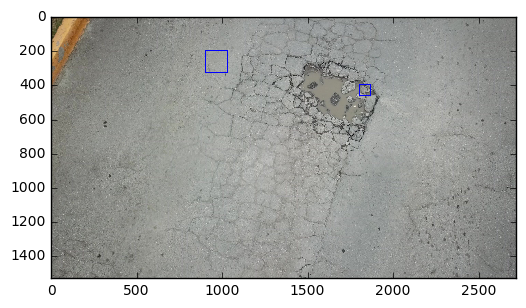

In [20]:
# Display the results before performing NMS
im_path = '../session3/DJI_0040 38.jpg'
im = imread(im_path)
clone = im.copy()
for (x_tl, y_tl, _, w, h) in detections:
#     print(x_tl, y_tl, _, w, h)
#     # Draw the detections
    cv2.rectangle(im, (x_tl, y_tl), (x_tl+w, y_tl+h), (0, 0, 255), thickness=5)

plt.imshow(im)#, cmap='gray' )
# cv2.imshow("Raw Detections before NMS", im)
#     cv2.waitKey()

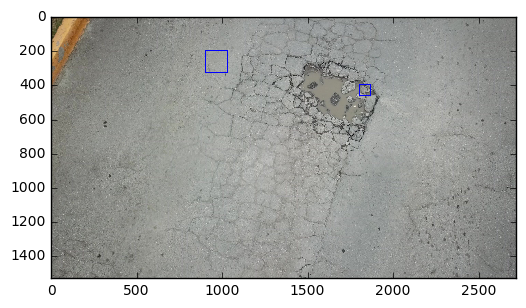

In [26]:
# Perform Non Maxima Suppression
threshold = 0
detections = nms(detections, threshold)

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in detections:
        # Draw the detections
    cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 255), thickness=5)

plt.imshow(clone, cmap = 'gray')
#     cv2.imshow("Final Detections after applying NMS", clone)
#     cv2.waitKey()